In [20]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import pandas as pd
from jax import grad, jit
from jax.nn import softmax
from jax.tree_util import Partial
from pyhgf.math import binary_surprise
from pyhgf.model import HGF
from pytensor.graph import Apply, Op

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF, Network
from pyhgf.response import first_level_gaussian_surprise

In [21]:
timeserie = load_data("continuous")

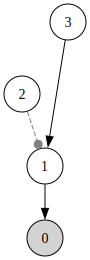

In [22]:
two_levels_continuous_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(
        precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0
    )
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
    .add_nodes(precision=1e0, tonic_volatility=0.0, value_children=1)
)

# Visualize the model structure
two_levels_continuous_hgf.plot_network()

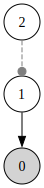

In [23]:
# Make a network with just a value parent for the second level (first level being input)

two_levels_continuous_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(
        precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0
    )
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
)

# Visualize the model structure
two_levels_continuous_hgf.plot_network()

In [24]:
# Feed two_levels_continuous_hgf with the timeserie data
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=timeserie)

In [31]:
print(two_levels_continuous_hgf.attributes[1]['mean'])
print(two_levels_continuous_hgf.node_trajectories[1]['mean'])

1.0357
[1.0357     1.0343866  1.0347939  1.0346824  1.0338115  1.0336285
 1.0332019  1.0331056  1.0318139  1.0307237  1.0287987  1.0272244
 1.0259771  1.0249867  1.0248637  1.0250063  1.0251693  1.0253494
 1.0257857  1.0276514  1.029937   1.0314032  1.0328344  1.0339701
 1.0348088  1.0359575  1.0374392  1.0392628  1.0411369  1.0437982
 1.0461327  1.047955   1.0491678  1.0500845  1.0516537  1.0545392
 1.0571288  1.0593847  1.0614611  1.0626677  1.0632191  1.0639616
 1.0656514  1.0672338  1.0685894  1.069978   1.0702367  1.0704699
 1.071789   1.0735191  1.0739243  1.0742532  1.0745462  1.0752621
 1.076024   1.0771438  1.0770004  1.0765789  1.0761915  1.0765653
 1.0769911  1.076198   1.0758374  1.0758964  1.0757201  1.0755676
 1.0750772  1.0752513  1.0750755  1.0744909  1.0729601  1.0712425
 1.0697204  1.068708   1.0674525  1.0658543  1.0649929  1.0643501
 1.0640758  1.0638231  1.0634278  1.0629199  1.0635555  1.0644199
 1.064822   1.0648752  1.0648558  1.0646961  1.0646421  1.0639366
 1.

# Understanding update functions

## Value Coupling

In the cells below we'll go through what happens when a simple 2-level HGF network with 1st level node having a value parent observes an input.

In [5]:
# Create a simple time series
timeserie = np.random.normal(0, 1, 10)

# Your network
two_levels_continuous_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(
        precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0
    )
    .add_nodes(precision=1e1, tonic_volatility=-2.0, value_children=1)
)

# Print network structure
print("Number of nodes:", len(two_levels_continuous_hgf.edges))
print("\nNode structure:")
for i, edge in enumerate(two_levels_continuous_hgf.edges):
    print(f"\nNode {i}:")
    print(f"  Type: {edge.node_type}")
    print(f"  Value children: {edge.value_children}")
    print(f"  Value parents: {edge.value_parents}")
    print(f"  Volatility children: {edge.volatility_children}")
    print(f"  Volatility parents: {edge.volatility_parents}")

# Generate the update sequence
from pyhgf.utils import get_update_sequence
update_seq = get_update_sequence(two_levels_continuous_hgf, "standard")

print("\n" + "="*60)
print("PREDICTION SEQUENCE:")
print("="*60)
for i, (node_idx, func) in enumerate(update_seq.prediction_steps):
    print(f"{i+1}. Node {node_idx}: {func.__name__}")

print("\n" + "="*60)
print("UPDATE SEQUENCE (prediction errors + posterior updates):")
print("="*60)
for i, (node_idx, func) in enumerate(update_seq.update_steps):
    print(f"{i+1}. Node {node_idx}: {func.__name__}")

Number of nodes: 3

Node structure:

Node 0:
  Type: 2
  Value children: None
  Value parents: (1,)
  Volatility children: None
  Volatility parents: None

Node 1:
  Type: 2
  Value children: (0,)
  Value parents: (2,)
  Volatility children: None
  Volatility parents: None

Node 2:
  Type: 2
  Value children: (1,)
  Value parents: None
  Volatility children: None
  Volatility parents: None

PREDICTION SEQUENCE:
1. Node 2: continuous_node_prediction
2. Node 1: continuous_node_prediction
3. Node 0: continuous_node_prediction

UPDATE SEQUENCE (prediction errors + posterior updates):
1. Node 0: continuous_node_prediction_error
2. Node 1: continuous_node_posterior_update
3. Node 1: continuous_node_prediction_error
4. Node 2: continuous_node_posterior_update


In [13]:
# Create a simple observation
observation = 1.5  # Single observation value
timeserie = np.array([observation])

# Your network
two_levels_continuous_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(
        precision=1e4, mean=observation, tonic_volatility=-2.0, value_children=0
    )
    .add_nodes(precision=1e1, tonic_volatility=-2.0, value_children=1)
)

print("="*70)
print("INITIAL STATE (before processing observation)")
print("="*70)
for i in range(3):
    attrs = two_levels_continuous_hgf.attributes[i]
    print(f"\nNode {i}:")
    print(f"  mean: {attrs['mean']:.6f}")
    print(f"  precision: {attrs['precision']:.6f}")
    print(f"  expected_mean: {attrs['expected_mean']:.6f}")
    print(f"  expected_precision: {attrs['expected_precision']:.6f}")
    print(f"  tonic_volatility: {attrs['tonic_volatility']:.6f}")
    if 'temp' in attrs:
        print(f"  temp.value_prediction_error: {attrs['temp']['value_prediction_error']:.6f}")
        print(f"  temp.effective_precision: {attrs['temp']['effective_precision']:.6f}")

print("\n" + "="*70)
print(f"PROCESSING OBSERVATION: {observation}")
print("="*70)

# Feed the observation through the network
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(timeserie)

print("\n" + "="*70)
print("FINAL STATE (after processing observation)")
print("="*70)
for i in range(3):
    attrs = two_levels_continuous_hgf.attributes[i]
    print(f"\nNode {i}:")
    print(f"  mean: {attrs['mean']:.6f}")
    print(f"  precision: {attrs['precision']:.6f}")
    print(f"  expected_mean: {attrs['expected_mean']:.6f}")
    print(f"  expected_precision: {attrs['expected_precision']:.6f}")
    print(f"  tonic_volatility: {attrs['tonic_volatility']:.6f}")
    if 'temp' in attrs:
        print(f"  temp.value_prediction_error: {attrs['temp']['value_prediction_error']:.6f}")
        print(f"  temp.effective_precision: {attrs['temp']['effective_precision']:.6f}")

# Also show the trajectory (time evolution)
print("\n" + "="*70)
print("NODE TRAJECTORIES (time series of beliefs)")
print("="*70)
print("\nNode 0 (input node):")
print(f"  mean: {two_levels_continuous_hgf.node_trajectories[0]['mean']}")
print(f"  precision: {two_levels_continuous_hgf.node_trajectories[0]['precision']}")

print("\nNode 1 (intermediate belief):")
print(f"  mean: {two_levels_continuous_hgf.node_trajectories[1]['mean']}")
print(f"  precision: {two_levels_continuous_hgf.node_trajectories[1]['precision']}")

print("\nNode 2 (top-level belief):")
print(f"  mean: {two_levels_continuous_hgf.node_trajectories[2]['mean']}")
print(f"  precision: {two_levels_continuous_hgf.node_trajectories[2]['precision']}")

INITIAL STATE (before processing observation)

Node 0:
  mean: 0.000000
  precision: 10000.000000
  expected_mean: 0.000000
  expected_precision: 1.000000
  tonic_volatility: -4.000000
  temp.value_prediction_error: 0.000000
  temp.effective_precision: 0.000000

Node 1:
  mean: 1.500000
  precision: 10000.000000
  expected_mean: 0.000000
  expected_precision: 1.000000
  tonic_volatility: -2.000000
  temp.value_prediction_error: 0.000000
  temp.effective_precision: 0.000000

Node 2:
  mean: 0.000000
  precision: 10.000000
  expected_mean: 0.000000
  expected_precision: 1.000000
  tonic_volatility: -2.000000
  temp.value_prediction_error: 0.000000
  temp.effective_precision: 0.000000

PROCESSING OBSERVATION: 1.5

FINAL STATE (after processing observation)

Node 0:
  mean: 0.000000
  precision: 10000.000000
  expected_mean: 0.000000
  expected_precision: 1.000000
  tonic_volatility: 0.000000
  temp.value_prediction_error: 0.000000
  temp.effective_precision: 0.000000

Node 1:
  mean: 1.50

In [15]:
from pyhgf.updates.prediction.continuous import continuous_node_prediction
from pyhgf.updates.prediction_error.continuous import continuous_node_prediction_error
from pyhgf.updates.posterior.continuous import continuous_node_posterior_update
from pyhgf.updates.observation import set_observation

# Create network
observation = 1.5
timeserie = np.array([observation])

network = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(
        precision=1e4, mean=observation, tonic_volatility=-13.0, value_children=0
    )
    .add_nodes(precision=1e1, tonic_volatility=-2.0, value_children=1)
)

# Get initial attributes
attributes = network.attributes
edges = network.edges

print("="*70)
print("STEP-BY-STEP EXECUTION")
print("="*70)

# PREDICTION PHASE
print("\n*** PREDICTION PHASE ***\n")

print("Step 1: Node 2 predicts")
print(f"  Before: mean={attributes[2]['mean']:.6f}, expected_mean={attributes[2]['expected_mean']:.6f}")
attributes = continuous_node_prediction(attributes=attributes, node_idx=2, edges=edges)
print(f"  After:  expected_mean={attributes[2]['expected_mean']:.6f}, expected_precision={attributes[2]['expected_precision']:.6f}")

print("\nStep 2: Node 1 predicts")
print(f"  Before: mean={attributes[1]['mean']:.6f}, expected_mean={attributes[1]['expected_mean']:.6f}")
attributes = continuous_node_prediction(attributes=attributes, node_idx=1, edges=edges)
print(f"  After:  expected_mean={attributes[1]['expected_mean']:.6f}, expected_precision={attributes[1]['expected_precision']:.6f}")

print("\nStep 3: Node 0 predicts")
print(f"  Before: mean={attributes[0]['mean']:.6f}, expected_mean={attributes[0]['expected_mean']:.6f}")
attributes = continuous_node_prediction(attributes=attributes, node_idx=0, edges=edges)
print(f"  After:  expected_mean={attributes[0]['expected_mean']:.6f}, expected_precision={attributes[0]['expected_precision']:.6f}")

# OBSERVATION PHASE
print("\n*** OBSERVATION PHASE ***\n")
print(f"Setting Node 0 observation to: {observation}")
# Fixed: set_observation takes (attributes, node_idx, values, observed)
attributes = set_observation(attributes=attributes, node_idx=0, values=observation, observed=1)
print(f"  Node 0 mean is now: {attributes[0]['mean']:.6f}")

# UPDATE PHASE
print("\n*** UPDATE PHASE ***\n")

print("Step 4: Node 0 computes prediction error")
print(f"  expected_mean={attributes[0]['expected_mean']:.6f}, observed_mean={attributes[0]['mean']:.6f}")
attributes = continuous_node_prediction_error(attributes=attributes, node_idx=0, edges=edges)
print(f"  Prediction error (δ₀): {attributes[0]['temp']['value_prediction_error']:.6f}")

print("\nStep 5: Node 1 updates posterior")
print(f"  Before: mean={attributes[1]['mean']:.6f}, precision={attributes[1]['precision']:.6f}")
attributes = continuous_node_posterior_update(attributes=attributes, node_idx=1, edges=edges)
print(f"  After:  mean={attributes[1]['mean']:.6f}, precision={attributes[1]['precision']:.6f}")

print("\nStep 6: Node 1 computes prediction error")
print(f"  expected_mean={attributes[1]['expected_mean']:.6f}, updated_mean={attributes[1]['mean']:.6f}")
attributes = continuous_node_prediction_error(attributes=attributes, node_idx=1, edges=edges)
print(f"  Prediction error (δ₁): {attributes[1]['temp']['value_prediction_error']:.6f}")

print("\nStep 7: Node 2 updates posterior")
print(f"  Before: mean={attributes[2]['mean']:.6f}, precision={attributes[2]['precision']:.6f}")
attributes = continuous_node_posterior_update(attributes=attributes, node_idx=2, edges=edges)
print(f"  After:  mean={attributes[2]['mean']:.6f}, precision={attributes[2]['precision']:.6f}")

print("\n" + "="*70)
print("DONE - All updates complete!")
print("="*70)

STEP-BY-STEP EXECUTION

*** PREDICTION PHASE ***

Step 1: Node 2 predicts
  Before: mean=0.000000, expected_mean=0.000000
  After:  expected_mean=0.000000, expected_precision=nan

Step 2: Node 1 predicts
  Before: mean=1.500000, expected_mean=0.000000
  After:  expected_mean=1.500000, expected_precision=nan

Step 3: Node 0 predicts
  Before: mean=0.000000, expected_mean=0.000000
  After:  expected_mean=0.000000, expected_precision=10000.000000

*** OBSERVATION PHASE ***

Setting Node 0 observation to: 1.5
  Node 0 mean is now: 1.500000

*** UPDATE PHASE ***

Step 4: Node 0 computes prediction error
  expected_mean=0.000000, observed_mean=1.500000
  Prediction error (δ₀): 1.500000

Step 5: Node 1 updates posterior
  Before: mean=1.500000, precision=10000.000000
  After:  mean=nan, precision=nan

Step 6: Node 1 computes prediction error
  expected_mean=1.500000, updated_mean=nan
  Prediction error (δ₁): nan

Step 7: Node 2 updates posterior
  Before: mean=0.000000, precision=10.000000
  

In [17]:
from pyhgf.updates.prediction.continuous import continuous_node_prediction
from pyhgf.updates.prediction_error.continuous import continuous_node_prediction_error
from pyhgf.updates.posterior.continuous import continuous_node_posterior_update
from pyhgf.updates.observation import set_observation

# Load real data
timeserie = load_data("continuous")

print("="*70)
print("DATASET INFO")
print("="*70)
print(f"Total observations: {len(timeserie)}")
print(f"First 10 observations: {timeserie[:10]}")
print(f"\nObservations 4-6 (what we'll focus on):")
print(f"  Observation 4: {timeserie[4]:.6f}")
print(f"  Observation 5: {timeserie[5]:.6f}")
print(f"  Observation 6: {timeserie[6]:.6f}")

# Create network
network = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(
        precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0
    )
    .add_nodes(precision=1e1, tonic_volatility=-2.0, value_children=1)
)

# Process first 5 observations to let network settle
print("\n" + "="*70)
print("SETTLING THE NETWORK (processing observations 0-4)")
print("="*70)
network_settled = network.input_data(timeserie[:5])
print("Network has processed 5 observations and settled into a stable state.")

# Get the current attributes after settling
attributes = network_settled.attributes
edges = network_settled.edges

print("\n" + "="*70)
print("STATE AFTER OBSERVATION 4 (before observation 5)")
print("="*70)
for i in range(3):
    print(f"\nNode {i}:")
    print(f"  mean: {attributes[i]['mean']:.6f}")
    print(f"  precision: {attributes[i]['precision']:.6f}")
    print(f"  expected_mean: {attributes[i]['expected_mean']:.6f}")
    print(f"  expected_precision: {attributes[i]['expected_precision']:.6f}")
    if 'temp' in attributes[i]:
        print(f"  temp.value_prediction_error: {attributes[i]['temp']['value_prediction_error']:.6f}")

# Now manually step through observation 5
observation_5 = timeserie[5]

print("\n" + "="*70)
print(f"PROCESSING OBSERVATION 5: {observation_5:.6f}")
print("="*70)

# PREDICTION PHASE
print("\n*** PREDICTION PHASE ***\n")

print("Step 1: Node 2 predicts")
print(f"  Before: mean={attributes[2]['mean']:.6f}, expected_mean={attributes[2]['expected_mean']:.6f}")
attributes = continuous_node_prediction(attributes=attributes, node_idx=2, edges=edges)
print(f"  After:  expected_mean={attributes[2]['expected_mean']:.6f}, expected_precision={attributes[2]['expected_precision']:.6f}")

print("\nStep 2: Node 1 predicts")
print(f"  Before: mean={attributes[1]['mean']:.6f}, expected_mean={attributes[1]['expected_mean']:.6f}")
print(f"  Parent (Node 2) expected_mean={attributes[2]['expected_mean']:.6f}")
attributes = continuous_node_prediction(attributes=attributes, node_idx=1, edges=edges)
print(f"  After:  expected_mean={attributes[1]['expected_mean']:.6f}, expected_precision={attributes[1]['expected_precision']:.6f}")

print("\nStep 3: Node 0 predicts")
print(f"  Before: mean={attributes[0]['mean']:.6f}, expected_mean={attributes[0]['expected_mean']:.6f}")
print(f"  Parent (Node 1) expected_mean={attributes[1]['expected_mean']:.6f}")
attributes = continuous_node_prediction(attributes=attributes, node_idx=0, edges=edges)
print(f"  After:  expected_mean={attributes[0]['expected_mean']:.6f}, expected_precision={attributes[0]['expected_precision']:.6f}")

# OBSERVATION PHASE
print("\n*** OBSERVATION PHASE ***\n")
print(f"Setting Node 0 observation to: {observation_5:.6f}")
attributes = set_observation(attributes=attributes, node_idx=0, values=observation_5, observed=1)
print(f"  Node 0 mean is now: {attributes[0]['mean']:.6f}")

# UPDATE PHASE
print("\n*** UPDATE PHASE ***\n")

print("Step 4: Node 0 computes prediction error")
print(f"  expected_mean={attributes[0]['expected_mean']:.6f}")
print(f"  observed_mean={attributes[0]['mean']:.6f}")
attributes = continuous_node_prediction_error(attributes=attributes, node_idx=0, edges=edges)
pe_0 = attributes[0]['temp']['value_prediction_error']
print(f"  --> Prediction error (δ₀): {pe_0:.6f}")
print(f"      (positive means observation > expectation)")

print("\nStep 5: Node 1 updates posterior (using Node 0's PE)")
print(f"  Before update:")
print(f"    mean={attributes[1]['mean']:.6f}, precision={attributes[1]['precision']:.6f}")
print(f"    Using child PE={pe_0:.6f}")
attributes = continuous_node_posterior_update(attributes=attributes, node_idx=1, edges=edges)
mean_change_1 = attributes[1]['mean'] - network_settled.attributes[1]['mean']
print(f"  After update:")
print(f"    mean={attributes[1]['mean']:.6f} (changed by {mean_change_1:.6f})")
print(f"    precision={attributes[1]['precision']:.6f}")

print("\nStep 6: Node 1 computes prediction error")
print(f"  expected_mean={attributes[1]['expected_mean']:.6f}")
print(f"  updated_mean={attributes[1]['mean']:.6f}")
attributes = continuous_node_prediction_error(attributes=attributes, node_idx=1, edges=edges)
pe_1 = attributes[1]['temp']['value_prediction_error']
print(f"  --> Prediction error (δ₁): {pe_1:.6f}")

print("\nStep 7: Node 2 updates posterior (using Node 1's PE)")
print(f"  Before update:")
print(f"    mean={attributes[2]['mean']:.6f}, precision={attributes[2]['precision']:.6f}")
print(f"    Using child PE={pe_1:.6f}")
attributes = continuous_node_posterior_update(attributes=attributes, node_idx=2, edges=edges)
mean_change_2 = attributes[2]['mean'] - network_settled.attributes[2]['mean']
print(f"  After update:")
print(f"    mean={attributes[2]['mean']:.6f} (changed by {mean_change_2:.6f})")
print(f"    precision={attributes[2]['precision']:.6f}")

print("\n" + "="*70)
print("SUMMARY: BELIEF UPDATES FROM OBSERVATION 5")
print("="*70)
print(f"Observation value: {observation_5:.6f}")
print(f"\nNode 0 (input):")
print(f"  PE: {pe_0:.6f}")
print(f"\nNode 1 (intermediate belief):")
print(f"  Mean updated by: {mean_change_1:.6f}")
print(f"  PE propagated up: {pe_1:.6f}")
print(f"\nNode 2 (top belief):")
print(f"  Mean updated by: {mean_change_2:.6f}")

# Verify by comparing with automatic processing
print("\n" + "="*70)
print("VERIFICATION: Compare with automatic network.input_data()")
print("="*70)
network_auto = network.input_data(timeserie[:6])
print(f"\nNode 1 mean (manual): {attributes[1]['mean']:.10f}")
print(f"Node 1 mean (auto):   {network_auto.attributes[1]['mean']:.10f}")
print(f"Difference: {abs(attributes[1]['mean'] - network_auto.attributes[1]['mean']):.2e}")
print(f"\nNode 2 mean (manual): {attributes[2]['mean']:.10f}")
print(f"Node 2 mean (auto):   {network_auto.attributes[2]['mean']:.10f}")
print(f"Difference: {abs(attributes[2]['mean'] - network_auto.attributes[2]['mean']):.2e}")

DATASET INFO
Total observations: 614
First 10 observations: [1.0357 1.0319 1.0359 1.0343 1.0303 1.0328 1.0311 1.0326 1.0247 1.0245]

Observations 4-6 (what we'll focus on):
  Observation 4: 1.030300
  Observation 5: 1.032800
  Observation 6: 1.031100

SETTLING THE NETWORK (processing observations 0-4)
Network has processed 5 observations and settled into a stable state.

STATE AFTER OBSERVATION 4 (before observation 5)

Node 0:
  mean: 0.000000
  precision: 10000.000000
  expected_mean: 0.000000
  expected_precision: 1.000000
  temp.value_prediction_error: 0.000000

Node 1:
  mean: 1.035700
  precision: 10000.000000
  expected_mean: 0.000000
  expected_precision: 1.000000
  temp.value_prediction_error: 0.000000

Node 2:
  mean: 0.000000
  precision: 10.000000
  expected_mean: 0.000000
  expected_precision: 1.000000
  temp.value_prediction_error: 0.000000

PROCESSING OBSERVATION 5: 1.032800

*** PREDICTION PHASE ***

Step 1: Node 2 predicts
  Before: mean=0.000000, expected_mean=0.00000

## Volatility Coupling

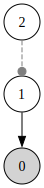

In [25]:
two_levels_continuous_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(
        precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0
    )
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
)

# Visualize the model structure
two_levels_continuous_hgf.plot_network()

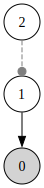

In [26]:
two_levels_continuous_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(
        precision=1e4, mean=timeserie[0], tonic_volatility=-13.0, value_children=0
    )
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
)

# Visualize the model structure
two_levels_continuous_hgf.plot_network()

array([<Axes: title={'left': 'State Node 2'}, ylabel='$\\mu_{2}$'>,
       <Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

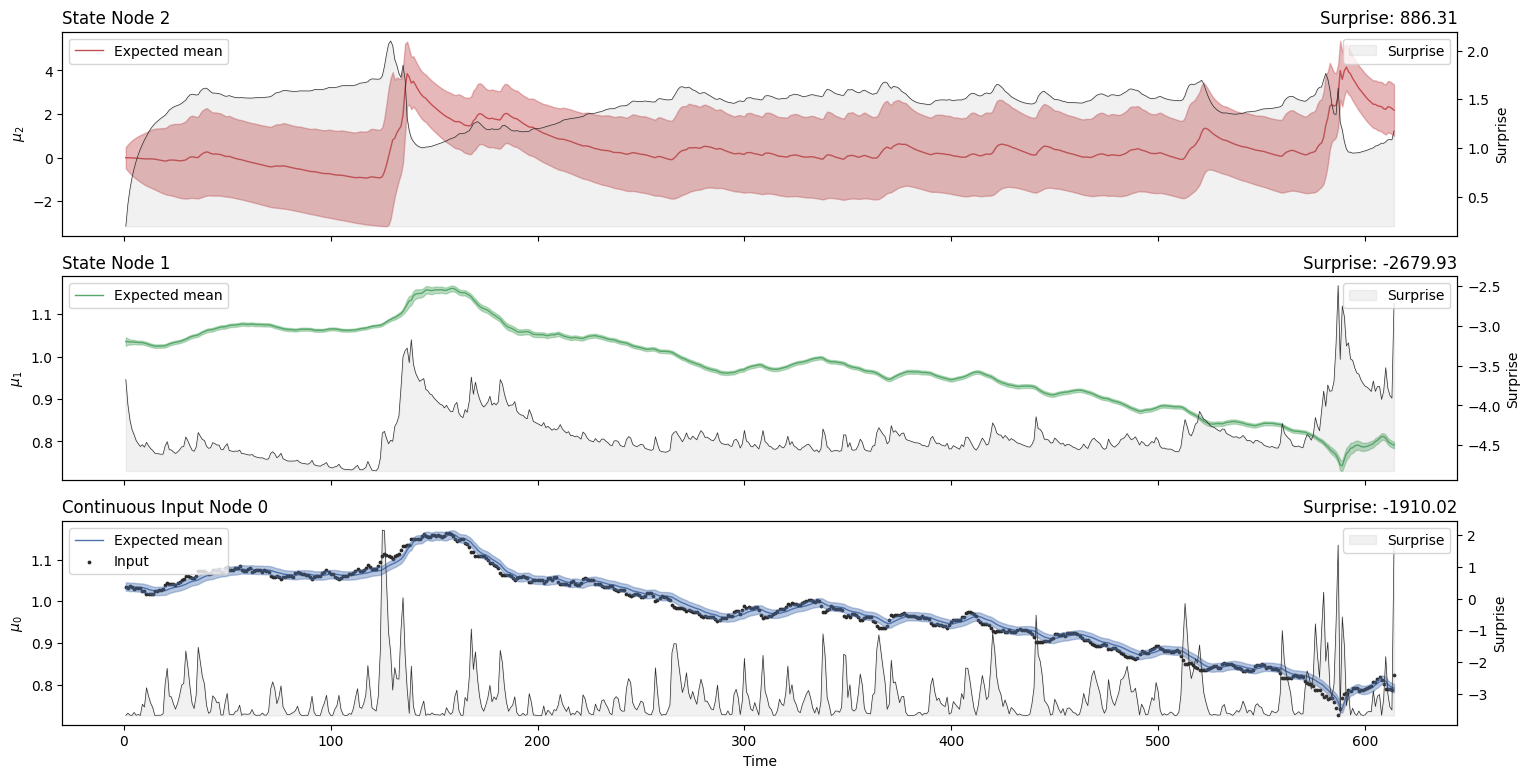

In [28]:
# Input data
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(
    input_data=timeserie
)

# Visualize the node trajectories
two_levels_continuous_hgf.plot_trajectories()

In [27]:
# Create network with new node type
network = (
    Network()
    .add_nodes(precision=1e4)  # Input node
    .add_nodes(
        kind="value-volatility",
        precision=1e4,
        mean=timeserie[0],
        tonic_volatility=-13.0,
        precision_vol=1e1,
        tonic_volatility_vol=-2.0,
        volatility_coupling_internal=1.0,
        value_children=0
    )
)

In [7]:
print(f"Number of nodes: {len(network.edges)}")
print("\nNode structure:")
for i, edge in enumerate(network.edges):
    print(f"\nNode {i}:")
    print(f"  Type: {edge.node_type}")
    print(f"  Value children: {edge.value_children}")
    print(f"  Value parents: {edge.value_parents}")
    print(f"  Volatility children: {edge.volatility_children}")
    print(f"  Volatility parents: {edge.volatility_parents}")

print("\n" + "="*70)
print("TEST 2: Check update sequence")
print("="*70)

from pyhgf.utils import get_update_sequence
update_seq = get_update_sequence(network, "standard")

print("\nPrediction sequence:")
for i, (node_idx, func) in enumerate(update_seq.prediction_steps):
    print(f"{i+1}. Node {node_idx}: {func.__name__}")

print("\nUpdate sequence:")
for i, (node_idx, func) in enumerate(update_seq.update_steps):
    print(f"{i+1}. Node {node_idx}: {func.__name__}")

print("\n" + "="*70)
print("TEST 3: Process data")
print("="*70)

# Process some data
network = network.input_data(timeserie[:10])

print("Successfully processed 10 observations!")
print("\nNode 1 (value-volatility) final state:")
attrs = network.attributes[1]
print(f"  Value level mean: {attrs['mean']:.6f}")
print(f"  Value level precision: {attrs['precision']:.6f}")
print(f"  Volatility level mean: {attrs['mean_vol']:.6f}")
print(f"  Volatility level precision: {attrs['precision_vol']:.6f}")

print("\n" + "="*70)
print("TEST 4: Compare with 3-node network")
print("="*70)

# Create equivalent 3-node network
network_3node = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(
        precision=1e4,
        mean=timeserie[0],
        tonic_volatility=-13.0,
        value_children=0
    )
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
)

network_3node = network_3node.input_data(timeserie[:10])

print("3-node network Node 1 (value):")
print(f"  mean: {network_3node.attributes[1]['mean']:.6f}")
print(f"  precision: {network_3node.attributes[1]['precision']:.6f}")

print("\n3-node network Node 2 (volatility):")
print(f"  mean: {network_3node.attributes[2]['mean']:.6f}")
print(f"  precision: {network_3node.attributes[2]['precision']:.6f}")

print("\n2-node value-volatility network Node 1:")
print(f"  value level mean: {network.attributes[1]['mean']:.6f}")
print(f"  value level precision: {network.attributes[1]['precision']:.6f}")
print(f"  volatility level mean: {network.attributes[1]['mean_vol']:.6f}")
print(f"  volatility level precision: {network.attributes[1]['precision_vol']:.6f}")

print("\nDifferences:")
print(f"  Value mean diff: {abs(network.attributes[1]['mean'] - network_3node.attributes[1]['mean']):.6e}")
print(f"  Volatility mean diff: {abs(network.attributes[1]['mean_vol'] - network_3node.attributes[2]['mean']):.6e}")

Number of nodes: 2

Node structure:

Node 0:
  Type: 2
  Value children: None
  Value parents: (1,)
  Volatility children: None
  Volatility parents: None

Node 1:
  Type: 6
  Value children: (0,)
  Value parents: None
  Volatility children: None
  Volatility parents: None

TEST 2: Check update sequence

Prediction sequence:
1. Node 1: value_volatility_node_prediction
2. Node 0: continuous_node_prediction

Update sequence:
1. Node 0: continuous_node_prediction_error
2. Node 1: value_volatility_node_posterior_update

TEST 3: Process data
Successfully processed 10 observations!

Node 1 (value-volatility) final state:
  Value level mean: 1.035700
  Value level precision: 10000.000000
  Volatility level mean: 0.000000
  Volatility level precision: 10.000000

TEST 4: Compare with 3-node network
3-node network Node 1 (value):
  mean: 1.035700
  precision: 10000.000000

3-node network Node 2 (volatility):
  mean: 0.000000
  precision: 10.000000

2-node value-volatility network Node 1:
  value

In [14]:
two_levels_continuous_hgf.attributes[1]

{'mean': np.float64(1.0357),
 'expected_mean': 0.0,
 'precision': 10000.0,
 'expected_precision': 1.0,
 'volatility_coupling_children': None,
 'volatility_coupling_parents': Array([1.], dtype=float32),
 'value_coupling_children': Array([1.], dtype=float32),
 'value_coupling_parents': None,
 'tonic_volatility': -13.0,
 'tonic_drift': 0.0,
 'autoconnection_strength': 1.0,
 'observed': 1,
 'temp': {'effective_precision': 0.0,
  'value_prediction_error': 0.0,
  'volatility_prediction_error': 0.0,
  'current_variance': 1.0}}

array([<Axes: title={'left': 'State Node 2'}, ylabel='$\\mu_{2}$'>,
       <Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

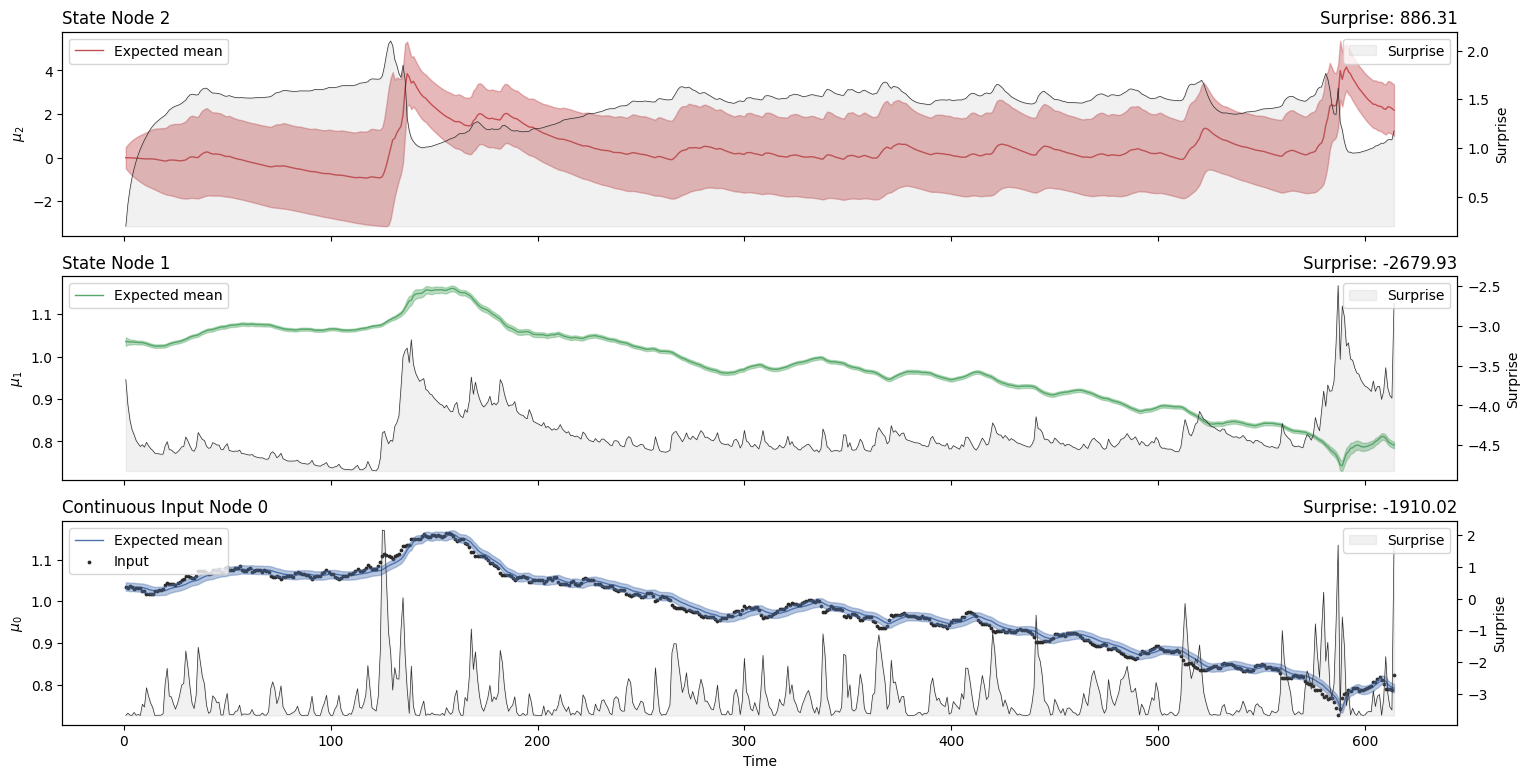

In [18]:
two_levels_continuous_hgf.plot_trajectories()

In [24]:
two_levels_continuous_hgf.attributes[1]['mean']

np.float64(1.0357)

In [29]:
# Input data
network = network.input_data(
    input_data=timeserie
)

In [32]:
network.node_trajectories[1]['mean']

Array([1.0357    , 1.0343866 , 1.034794  , 1.0346824 , 1.0338103 ,
       1.033627  , 1.0331988 , 1.0331024 , 1.0317984 , 1.0306966 ,
       1.0287449 , 1.0271506 , 1.0258902 , 1.0248919 , 1.0247794 ,
       1.0249377 , 1.0251155 , 1.0253099 , 1.0257713 , 1.0277355 ,
       1.0301363 , 1.0316547 , 1.0331278 , 1.0342828 , 1.0351228 ,
       1.0362918 , 1.0378139 , 1.0396954 , 1.0416212 , 1.0443662 ,
       1.0467283 , 1.0485237 , 1.0496781 , 1.050532  , 1.0520477 ,
       1.0548862 , 1.0573986 , 1.0595466 , 1.0614927 , 1.0626094 ,
       1.0631242 , 1.0638181 , 1.0653915 , 1.066885  , 1.0681841 ,
       1.0695252 , 1.0698285 , 1.0701034 , 1.0713999 , 1.0731014 ,
       1.0735475 , 1.0739174 , 1.0742497 , 1.0749959 , 1.0757914 ,
       1.0769502 , 1.0768316 , 1.0764227 , 1.076043  , 1.0764554 ,
       1.0769218 , 1.076082  , 1.0757079 , 1.0757905 , 1.0756105 ,
       1.0754557 , 1.0749179 , 1.0751386 , 1.0749519 , 1.0742892 ,
       1.0725194 , 1.0705502 , 1.0688417 , 1.067762  , 1.06640

In [33]:
two_levels_continuous_hgf.node_trajectories[1]['mean']

Array([1.0357    , 1.0343866 , 1.0347939 , 1.0346824 , 1.0338115 ,
       1.0336285 , 1.0332019 , 1.0331056 , 1.0318139 , 1.0307237 ,
       1.0287987 , 1.0272244 , 1.0259771 , 1.0249867 , 1.0248637 ,
       1.0250063 , 1.0251693 , 1.0253494 , 1.0257857 , 1.0276514 ,
       1.029937  , 1.0314032 , 1.0328344 , 1.0339701 , 1.0348088 ,
       1.0359575 , 1.0374392 , 1.0392628 , 1.0411369 , 1.0437982 ,
       1.0461327 , 1.047955  , 1.0491678 , 1.0500845 , 1.0516537 ,
       1.0545392 , 1.0571288 , 1.0593847 , 1.0614611 , 1.0626677 ,
       1.0632191 , 1.0639616 , 1.0656514 , 1.0672338 , 1.0685894 ,
       1.069978  , 1.0702367 , 1.0704699 , 1.071789  , 1.0735191 ,
       1.0739243 , 1.0742532 , 1.0745462 , 1.0752621 , 1.076024  ,
       1.0771438 , 1.0770004 , 1.0765789 , 1.0761915 , 1.0765653 ,
       1.0769911 , 1.076198  , 1.0758374 , 1.0758964 , 1.0757201 ,
       1.0755676 , 1.0750772 , 1.0752513 , 1.0750755 , 1.0744909 ,
       1.0729601 , 1.0712425 , 1.0697204 , 1.068708  , 1.06745

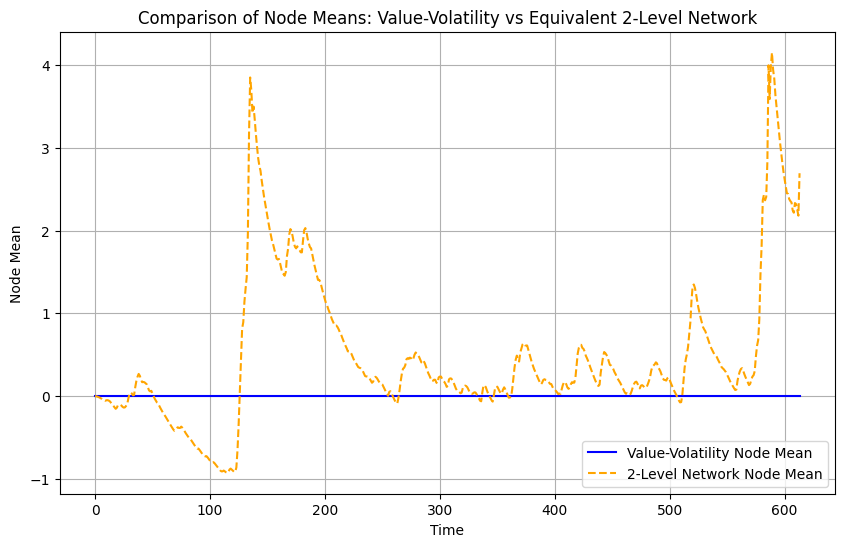

In [31]:
# Make a plot comparing network.node_trajectories[1]['mean'] and two_levels_continuous_hgf.node_trajectories[1]['mean']
plt.figure(figsize=(10, 6))
plt.plot(
    network.node_trajectories[1]['mean_vol'],
    label='Value-Volatility Node Mean',
    color='blue'
)
plt.plot(
    two_levels_continuous_hgf.node_trajectories[2]['mean'],
    label='2-Level Network Node Mean',
    color='orange',
    linestyle='--'
)
plt.title('Comparison of Node Means: Value-Volatility vs Equivalent 2-Level Network')
plt.xlabel('Time')
plt.ylabel('Node Mean')
plt.legend()
plt.grid()
plt.show()

In [9]:
# Okay let's make two value-volatility nodes stacked on top of each other.

network = (
    Network()
    .add_nodes(precision=1e4)  # Input node
    .add_nodes(
        kind="value-volatility",
        precision=1e4,
        mean=timeserie[0],
        tonic_volatility=-13.0,
        precision_vol=1e1,
        tonic_volatility_vol=-2.0,
        volatility_coupling_internal=1.0,
        value_children=0
    )
    .add_nodes(
        kind="value-volatility",
        precision=1e1,
        tonic_volatility=-2.0,
        precision_vol=1e0,
        tonic_volatility_vol=0.0,
        volatility_coupling_internal=1.0,
        value_children=1
    )
)

# Process some data
network = network.input_data(timeserie)

In [12]:
# Now we make an equivalent 4-node network

network_4node = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(
        precision=1e4,
        mean=timeserie[0],
        tonic_volatility=-13.0,
        value_children=0
    )
    .add_nodes(precision=1e1, tonic_volatility=-2.0, volatility_children=1)
    .add_nodes(precision=1e1, tonic_volatility=-2.0, value_children=1)
    .add_nodes(precision=1e0, tonic_volatility=0.0, volatility_children=3)
)

# Visualize the model structure
network_4node.plot_network()

# Process some data
network_4node = network_4node.input_data(timeserie)

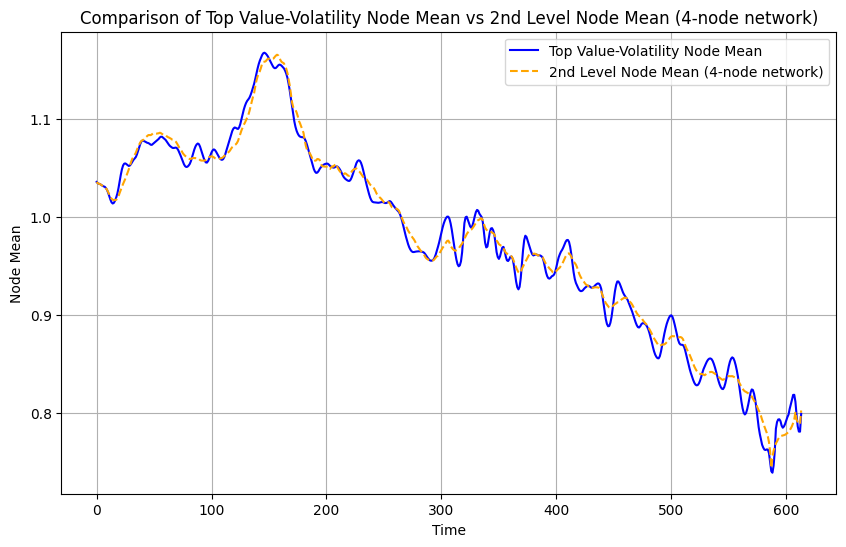

In [14]:
# Compare the node trajectories between the two networks like before
plt.figure(figsize=(10, 6))
plt.plot(
    network.node_trajectories[1]['mean'],
    label='Top Value-Volatility Node Mean',
    color='blue'
)
plt.plot(
    network_4node.node_trajectories[1]['mean'],
    label='2nd Level Node Mean (4-node network)',
    color='orange',
    linestyle='--'
)
plt.title('Comparison of Top Value-Volatility Node Mean vs 2nd Level Node Mean (4-node network)')
plt.xlabel('Time')
plt.ylabel('Node Mean')
plt.legend()
plt.grid()
plt.show()

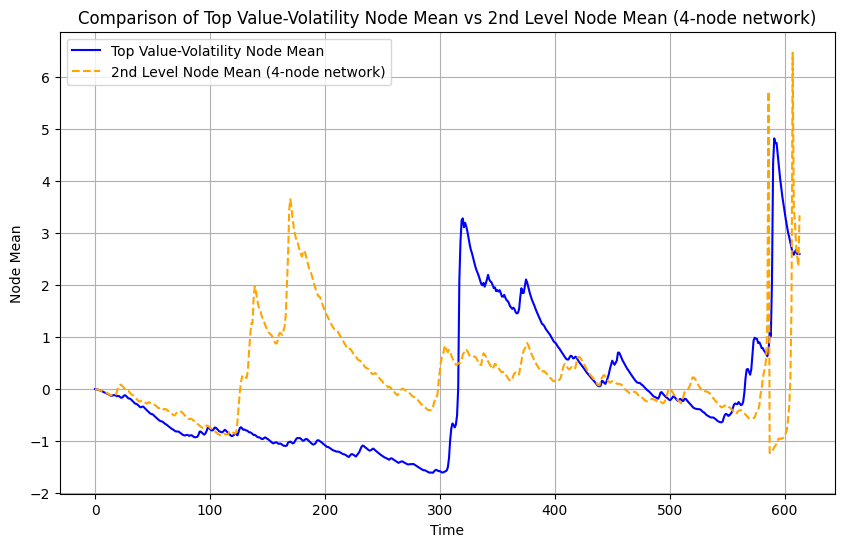

In [18]:
# Compare the node trajectories between the two networks like before
plt.figure(figsize=(10, 6))
plt.plot(
    network.node_trajectories[1]['mean_vol'],
    label='Top Value-Volatility Node Mean',
    color='blue'
)
plt.plot(
    network_4node.node_trajectories[2]['mean'],
    label='2nd Level Node Mean (4-node network)',
    color='orange',
    linestyle='--'
)
plt.title('Comparison of Top Value-Volatility Node Mean vs 2nd Level Node Mean (4-node network)')
plt.xlabel('Time')
plt.ylabel('Node Mean')
plt.legend()
plt.grid()
plt.show()